# Twitter Sentiment Analysis

Importing necessary packages

In [2]:
# Packages
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt

#plotly
import plotly.express as px

#seaborn
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Initialisation

In [32]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 8192

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.6)

# EXPORT
KERAS_MODEL = "keras_model.h5"
WORD2VEC_MODEL = "word2vec_model.w2v"
TOKENIZER_MODEL = "tokenizer_model.pkl"
ENCODER_MODEL = "encoder_model.pkl"

Reading Input Dataset

In [5]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
print("Dataset size:", len(df))
df.head(5)

Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Mapping target label to string

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.08 s


Text(0.5, 1.0, 'Dataset labels distribuition')

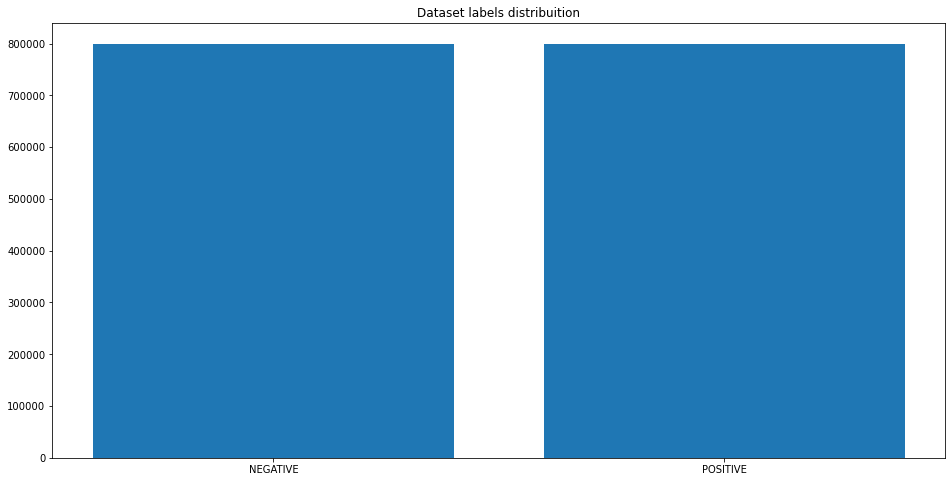

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")


Pre-processing the Dataset

In [9]:
#pre-process dataset
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 42s


Split and Train Dataset

In [13]:
#Split and train dataset
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


WORD2VEC

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 5 s


In [15]:
#Word2Vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-08-14 16:23:59,547 : INFO : collecting all words and their counts
2020-08-14 16:23:59,547 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-14 16:23:59,603 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-08-14 16:23:59,649 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-08-14 16:23:59,681 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-08-14 16:23:59,704 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-08-14 16:23:59,740 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-08-14 16:23:59,770 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-08-14 16:23:59,804 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-08-14 16:23:59,839 : INFO : PROGRESS: at s

2020-08-14 16:24:02,656 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-08-14 16:24:02,702 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-08-14 16:24:02,755 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-08-14 16:24:02,795 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-08-14 16:24:02,838 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-08-14 16:24:02,887 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-08-14 16:24:02,932 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-08-14 16:24:02,975 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-08-14 16:24:03,029 : INFO : PROGRESS: at sentence #800000, processed 577088

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-14 16:25:28,710 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-14 16:25:29,843 : INFO : EPOCH 1 - PROGRESS: at 6.29% examples, 515055 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:25:30,831 : INFO : EPOCH 1 - PROGRESS: at 13.58% examples, 555846 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:25:31,849 : INFO : EPOCH 1 - PROGRESS: at 20.27% examples, 553613 words/s, in_qsize 16, out_qsize 1
2020-08-14 16:25:32,842 : INFO : EPOCH 1 - PROGRESS: at 27.53% examples, 564337 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:25:33,843 : INFO : EPOCH 1 - PROGRESS: at 34.57% examples, 566487 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:25:34,859 : INFO : EPOCH 1 - PROGRESS: at 41.59% examples, 568185 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:25:35,872 : INFO : EPOCH 1 - PROGRESS: at 48.94% examples, 571700 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:25:36,901 : INFO : EPOCH 1 - PROGRESS: 

2020-08-14 16:26:21,676 : INFO : EPOCH 4 - PROGRESS: at 70.26% examples, 566950 words/s, in_qsize 15, out_qsize 1
2020-08-14 16:26:22,730 : INFO : EPOCH 4 - PROGRESS: at 77.74% examples, 568030 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:26:23,740 : INFO : EPOCH 4 - PROGRESS: at 85.23% examples, 571534 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:26:24,763 : INFO : EPOCH 4 - PROGRESS: at 92.50% examples, 572318 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:26:25,658 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 16:26:25,658 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 16:26:25,666 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 16:26:25,672 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 16:26:25,681 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 16:26:25,688 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-08-14 16:27:08,833 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 16:27:08,834 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 16:27:08,843 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 16:27:08,843 : INFO : EPOCH - 7 : training on 9227204 raw words (8221698 effective words) took 14.3s, 575834 effective words/s
2020-08-14 16:27:09,859 : INFO : EPOCH 8 - PROGRESS: at 5.86% examples, 479187 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:10,879 : INFO : EPOCH 8 - PROGRESS: at 12.60% examples, 512286 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:11,876 : INFO : EPOCH 8 - PROGRESS: at 19.40% examples, 528157 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:12,909 : INFO : EPOCH 8 - PROGRESS: at 26.67% examples, 540684 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:13,914 : INFO : EPOCH 8 - PROGRESS: at 33.92% examples, 551094 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:14,

2020-08-14 16:27:56,965 : INFO : EPOCH 11 - PROGRESS: at 34.57% examples, 561325 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:27:57,971 : INFO : EPOCH 11 - PROGRESS: at 41.70% examples, 564835 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:58,978 : INFO : EPOCH 11 - PROGRESS: at 48.62% examples, 564837 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:27:59,987 : INFO : EPOCH 11 - PROGRESS: at 55.64% examples, 566341 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:28:01,020 : INFO : EPOCH 11 - PROGRESS: at 62.36% examples, 562551 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:28:02,030 : INFO : EPOCH 11 - PROGRESS: at 69.62% examples, 565318 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:28:03,053 : INFO : EPOCH 11 - PROGRESS: at 76.98% examples, 567967 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:28:04,076 : INFO : EPOCH 11 - PROGRESS: at 84.26% examples, 569505 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:28:05,127 : INFO : EPOCH 11 - PROGRESS: at 91.42% examples, 568430

2020-08-14 16:28:47,328 : INFO : EPOCH 14 - PROGRESS: at 85.13% examples, 573965 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:28:48,336 : INFO : EPOCH 14 - PROGRESS: at 92.50% examples, 575775 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:28:49,249 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 16:28:49,249 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 16:28:49,261 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 16:28:49,272 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 16:28:49,282 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 16:28:49,288 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 16:28:49,300 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 16:28:49,304 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 16:28:49,306 : INFO : EPOCH - 1

2020-08-14 16:29:32,908 : INFO : EPOCH - 17 : training on 9227204 raw words (8222574 effective words) took 14.2s, 579852 effective words/s
2020-08-14 16:29:33,936 : INFO : EPOCH 18 - PROGRESS: at 5.86% examples, 471160 words/s, in_qsize 13, out_qsize 2
2020-08-14 16:29:34,953 : INFO : EPOCH 18 - PROGRESS: at 12.71% examples, 511885 words/s, in_qsize 13, out_qsize 2
2020-08-14 16:29:35,961 : INFO : EPOCH 18 - PROGRESS: at 19.94% examples, 537535 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:29:36,971 : INFO : EPOCH 18 - PROGRESS: at 26.99% examples, 545916 words/s, in_qsize 15, out_qsize 1
2020-08-14 16:29:38,021 : INFO : EPOCH 18 - PROGRESS: at 33.81% examples, 544267 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:29:39,031 : INFO : EPOCH 18 - PROGRESS: at 41.05% examples, 551810 words/s, in_qsize 16, out_qsize 1
2020-08-14 16:29:40,041 : INFO : EPOCH 18 - PROGRESS: at 48.40% examples, 558703 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:29:41,042 : INFO : EPOCH 18 - PROGRESS: at 

2020-08-14 16:30:23,741 : INFO : EPOCH 21 - PROGRESS: at 51.10% examples, 585154 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:30:24,761 : INFO : EPOCH 21 - PROGRESS: at 58.14% examples, 583456 words/s, in_qsize 15, out_qsize 2
2020-08-14 16:30:25,788 : INFO : EPOCH 21 - PROGRESS: at 65.39% examples, 583112 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:30:26,797 : INFO : EPOCH 21 - PROGRESS: at 72.43% examples, 581968 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:30:27,793 : INFO : EPOCH 21 - PROGRESS: at 79.60% examples, 582469 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:30:28,806 : INFO : EPOCH 21 - PROGRESS: at 86.32% examples, 579573 words/s, in_qsize 13, out_qsize 2
2020-08-14 16:30:29,813 : INFO : EPOCH 21 - PROGRESS: at 93.37% examples, 579270 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:30:30,586 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 16:30:30,588 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 16

2020-08-14 16:31:14,659 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 16:31:14,664 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 16:31:14,664 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 16:31:14,672 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 16:31:14,681 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 16:31:14,707 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 16:31:14,710 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 16:31:14,721 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 16:31:14,723 : INFO : EPOCH - 24 : training on 9227204 raw words (8222441 effective words) took 14.6s, 562585 effective words/s
2020-08-14 16:31:15,760 : INFO : EPOCH 25 - PROGRESS: at 5.76% examples, 461803 words/s, in_qsize 14, out_qsize 1
2020-08-14 16:31:16

2020-08-14 16:31:59,762 : INFO : EPOCH 28 - PROGRESS: at 13.14% examples, 527665 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:00,774 : INFO : EPOCH 28 - PROGRESS: at 19.84% examples, 533677 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:01,778 : INFO : EPOCH 28 - PROGRESS: at 27.10% examples, 547581 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:02,790 : INFO : EPOCH 28 - PROGRESS: at 34.24% examples, 554149 words/s, in_qsize 16, out_qsize 1
2020-08-14 16:32:03,790 : INFO : EPOCH 28 - PROGRESS: at 41.59% examples, 562257 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:32:04,820 : INFO : EPOCH 28 - PROGRESS: at 48.30% examples, 559297 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:05,818 : INFO : EPOCH 28 - PROGRESS: at 55.42% examples, 562473 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:06,844 : INFO : EPOCH 28 - PROGRESS: at 62.68% examples, 565266 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:07,835 : INFO : EPOCH 28 - PROGRESS: at 69.83% examples, 567249

2020-08-14 16:32:50,878 : INFO : EPOCH 31 - PROGRESS: at 69.61% examples, 561860 words/s, in_qsize 15, out_qsize 0
2020-08-14 16:32:51,872 : INFO : EPOCH 31 - PROGRESS: at 76.33% examples, 560728 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:32:52,902 : INFO : EPOCH 31 - PROGRESS: at 83.62% examples, 562225 words/s, in_qsize 13, out_qsize 2
2020-08-14 16:32:53,918 : INFO : EPOCH 31 - PROGRESS: at 90.76% examples, 563591 words/s, in_qsize 16, out_qsize 2
2020-08-14 16:32:54,925 : INFO : EPOCH 31 - PROGRESS: at 97.61% examples, 563199 words/s, in_qsize 16, out_qsize 0
2020-08-14 16:32:55,113 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 16:32:55,118 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 16:32:55,139 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 16:32:55,139 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 16:32:55,147 : INFO : worker thread finished; awai

Wall time: 7min 40s


(263124591, 295270528)

In [19]:
w2v_model.most_similar("great")

c:\users\yoges\pycharmprojects\tweetsenti\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-14 16:33:24,105 : INFO : precomputing L2-norms of word weight vectors


[('fantastic', 0.7194418907165527),
 ('good', 0.6982159614562988),
 ('wonderful', 0.6960442066192627),
 ('awesome', 0.6814688444137573),
 ('amazing', 0.6574661731719971),
 ('fab', 0.6134650111198425),
 ('fabulous', 0.6126446723937988),
 ('excellent', 0.5731711387634277),
 ('nice', 0.5721452236175537),
 ('gr8', 0.5631394386291504)]

Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 33.6 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 49.2 s


Label Encoder

In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

Embedding Layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build Model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


Compile Model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [30]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Training

In [33]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

 15/141 [==>...........................] - ETA: 5:15:27 - loss: 0.5924 - accuracy: 0.6806

KeyboardInterrupt: 

Evaluate

In [34]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 440s 11s/step - loss: 0.5437 - accuracy: 0.7324

ACCURACY: 0.7324437499046326
LOSS: 0.5437046885490417
Wall time: 7min 30s


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predictions

In [44]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= 0.5:
            label = NEGATIVE
        elif score >= 0.7:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [45]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [46]:
predict("He's a fantastic cricketer")

{'label': 'POSITIVE',
 'score': 0.9222733974456787,
 'elapsed_time': 0.056458234786987305}

In [47]:
predict("I hate seafood")

{'label': 'NEGATIVE',
 'score': 0.15010875463485718,
 'elapsed_time': 0.05885577201843262}

In [48]:
predict("It is a fish")

{'label': 'NEUTRAL',
 'score': 0.5154789090156555,
 'elapsed_time': 0.06282615661621094}

Confusion Matrix

In [49]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 506s 13s/step
Wall time: 8min 37s


In [50]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

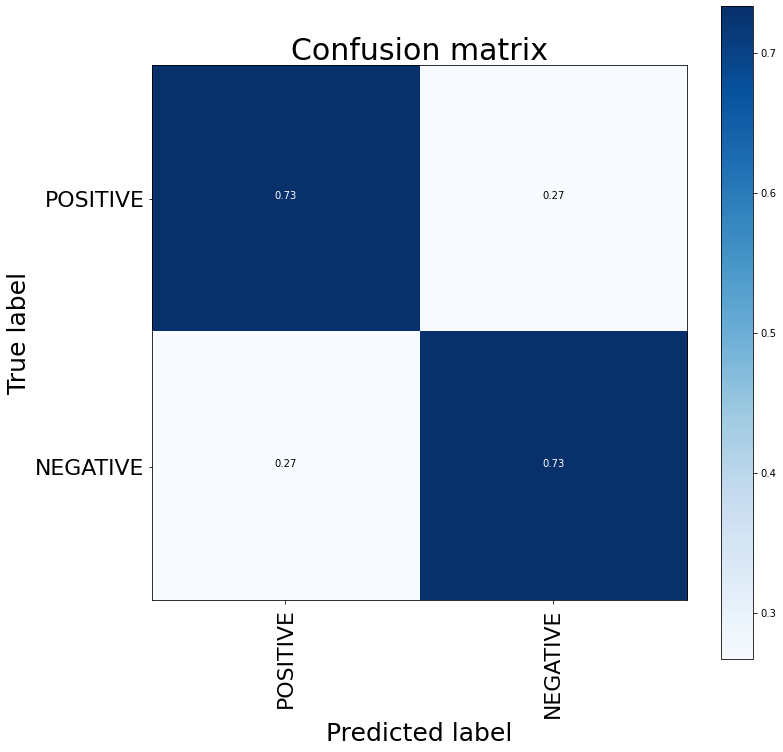

Wall time: 1.18 s


In [51]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Classification Report

In [52]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.73      0.73    159494
    POSITIVE       0.73      0.73      0.73    160506

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



Accuracy

In [53]:
accuracy_score(y_test_1d, y_pred_1d)

0.73244375

In [ ]:
Save Model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)